In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from scipy.interpolate import UnivariateSpline
import xgboost as xgb

C:\Users\zydar\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
links_infos = pd.read_csv('data/gy_contest_link_info.txt', delimiter=';')
print links_infos.count()
links_infos.head()

link_ID       132
length        132
width         132
link_class    132
dtype: int64


,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


In [4]:
links_tops = pd.read_csv('data/gy_contest_link_top.txt', delimiter=';')
print links_tops.count()
links_tops.head()

link_ID      132
in_links     126
out_links    125
dtype: int64


,link_ID,in_links,out_links
0,4377906289869500514,4377906285525800514,4377906281969500514
1,4377906284594800514,4377906284514600514,4377906285594800514
2,4377906289425800514,NaN,4377906284653600514
3,4377906284525800514,4377906281234600514,4377906280334600514
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514


In [4]:
df = pd.read_csv('data/quaterfinal_gy_cmp_training_traveltime.txt', delimiter=';')
print df.count()
df.head()

link_ID          10632044
date             10632044
time_interval    10632044
travel_time      10632044
dtype: int64


,link_ID,date,time_interval,travel_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4


## 分析数据特性

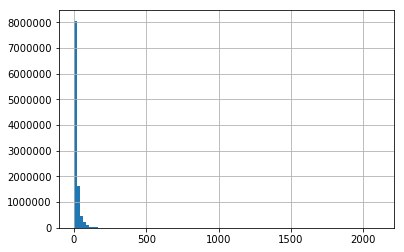

In [5]:
df['travel_time'].hist(bins=100)
plt.show()

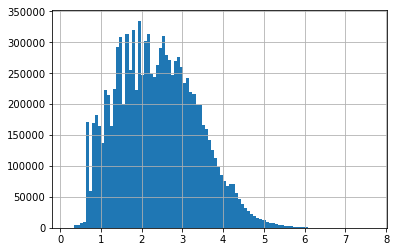

In [6]:
df['travel_time'] = np.log1p(df['travel_time'])  # log(1+x)
df['travel_time'].hist(bins=100)
plt.show()

- 可以看出，travel_time的分布是长尾分布，大部分数据集中在很小的区域，故做log特征变换
- 为避免x=0出现负无穷大，使用log(1+x)

## 数据平滑

In [8]:
def quantile_clip(group):
#     group.plot()
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
#     group.plot()
#     plt.show()
    return group
df['travel_time'] = df.groupby(['link_ID', 'date'])['travel_time'].transform(quantile_clip)

## 缺失值补全

In [156]:
date_list = np.sort(df['date'].unique())  #2016.07.01-2016.07.31 2017.04.01-2017.07.31
# print date_list
df['time_interval_begin'] =  pd.to_datetime(df['time_interval'].map(lambda x: x[1:20]))

In [100]:
date_range = pd.date_range('2016-07-01 00:00:00', '2016-07-31 23:58:00', freq='2min').append(
    pd.date_range('2017-04-01 00:00:00', '2017-07-31 23:58:00', freq='2min'))

new_index = pd.MultiIndex.from_product([links_infos['link_ID'].unique(), date_range],
                                       names=['link_ID', 'time_interval_begin'])
df_new_index = pd.DataFrame(index=new_index).reset_index()

In [101]:
df_fillna = pd.merge(df_new_index, df, on=['link_ID', 'time_interval_begin'], how='left')

In [141]:
# 预测2017年7月份，8，15，18时的数据
df_select = df_fillna.loc[df_fillna['time_interval_begin'].dt.hour.isin([6,7,8,13,14,15,16,17,18])]  # 筛选出6,7,8,13,14,15,16,17,18小时的数据
df_select = df_select.loc[~(
    (df_select['time_interval_begin'].dt.year == 2017) & 
    (df_select['time_interval_begin'].dt.month == 7) & 
    (df_select['time_interval_begin'].dt.hour.isin([8,15,18]))
)]
df_select['date'] = df_select['time_interval_begin'].dt.strftime('%Y-%m-%d')

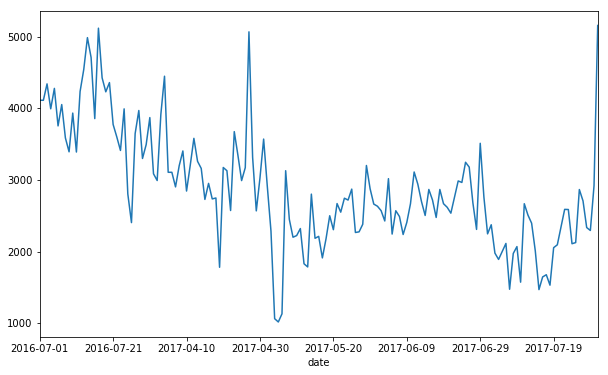

In [144]:
df_select.loc[df_select['travel_time'].isnull() == True].groupby('date')['link_ID'].count().plot(figsize=(10,6))
plt.show()

## 加入2017年3月份的数据，使用3，4，5，6四个月来预测7月

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def quantile_clip(group):
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
    return group

df = pd.read_csv('data/quaterfinal_gy_cmp_training_traveltime.txt', delimiter=';')
df['time_interval_begin'] = pd.to_datetime(df['time_interval'].map(lambda x: x[1:20]))
df_second = pd.read_csv('data/gy_contest_traveltime_training_data_second.txt', delimiter=';')
df_second = df_second.rename(columns={'linkID': 'link_ID'})
df_second['time_interval_begin'] = pd.to_datetime(df_second['time_interval'].map(lambda x: x[1:20]))
df_second = df_second.loc[(df_second['time_interval_begin'] >= pd.to_datetime('2017-03-01')) & 
                          (df_second['time_interval_begin'] <= pd.to_datetime('2017-03-31'))]
df_concat = pd.concat([df, df_second])
df_concat = df_concat.drop(['time_interval'], axis=1)
df_concat['travel_time'] = np.log1p(df_concat['travel_time'])
df_concat['travel_time'] = df_concat.groupby(['link_ID', 'date'])['travel_time'].transform(quantile_clip)
df_select = df_concat.loc[(df_concat['time_interval_begin'].dt.hour.isin([6, 7, 8, 13, 14, 15, 16, 17, 18]))]
# df_select.to_csv('data/df_select.txt', header=True, index=None, sep=';', mode='w')

print df_concat.count()
df_concat.head()

link_ID                13028218
date                   13028218
travel_time            13028218
time_interval_begin    13028218
dtype: int64


,link_ID,date,travel_time,time_interval_begin
0,4377906283422600514,2017-05-06,1.386294,2017-05-06 11:04:00
1,3377906289434510514,2017-05-06,0.693147,2017-05-06 10:42:00
2,3377906285934510514,2017-05-06,3.589059,2017-05-06 11:56:00
3,3377906285934510514,2017-05-06,3.303217,2017-05-06 17:46:00
4,3377906287934510514,2017-05-06,2.251292,2017-05-06 10:52:00


In [5]:
date_range = pd.date_range('2017-03-01 00:00:00', '2017-07-31 23:58:00', freq='2min')

new_index = pd.MultiIndex.from_product([links_infos['link_ID'].unique(), date_range],
                                       names=['link_ID', 'time_interval_begin'])

new_df = pd.DataFrame(index=new_index).reset_index()

df_fillna = pd.merge(new_df, df_concat, on=['link_ID', 'time_interval_begin'], how='left')
df_fillna = df_fillna.loc[(df_fillna['time_interval_begin'].dt.hour.isin([6, 7, 8, 13, 14, 15, 16, 17, 18]))]

In [6]:
df_fillna = df_fillna.loc[~(
    (df_fillna['time_interval_begin'].dt.year == 2017) & 
    (df_fillna['time_interval_begin'].dt.month == 7) & 
    (df_fillna['time_interval_begin'].dt.hour.isin([8, 15, 18]))
)]

df_fillna = df_fillna.loc[~(
    (df_fillna['time_interval_begin'].dt.year == 2017) & 
    (df_fillna['time_interval_begin'].dt.month == 3) & 
    (df_fillna['time_interval_begin'].dt.day == 31)
)]

df_fillna['date'] = df_fillna['time_interval_begin'].dt.strftime('%Y-%m-%d')
df_fillna.to_csv('data/df_fillna.txt', header=True, index=None, sep=';', mode='w')

print df_fillna.count()
df_fillna.head()

link_ID                5049000
time_interval_begin    5049000
date                   5049000
travel_time            4626850
dtype: int64


,link_ID,time_interval_begin,date,travel_time
180,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752
181,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752
182,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752
183,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752
184,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752


## 开始补全

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/df_fillna.csv', delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})

In [6]:
# Seasonal date trend

def date_trend(group):  # 每个group为一条link
    tmp = group.groupby('date_hour').mean().reset_index()  # 每天travel_time的平均值

    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]

    y = tmp['travel_time'].values
    nans, x = nan_helper(y)  # x表示'travel_time'中的非零下标
    if group.link_ID.values[0] in ['3377906282328510514', '3377906283328510514', '4377906280784800514',
                                   '9377906281555510514']:
        tmp['date_trend'] = group['travel_time'].median()
    else:
        regr = linear_model.LinearRegression()
        regr.fit(x(~nans).reshape(-1, 1), y[~nans].reshape(-1, 1))
        tmp['date_trend'] = regr.predict(tmp.index.values.reshape(-1, 1)).ravel()
    
    group = pd.merge(group, tmp[['date_trend', 'date_hour']], on='date_hour', how='left')
#     plt.plot(tmp.index, tmp['date_trend'], 'o', tmp.index, tmp['travel_time'], 'ro')
#     plt.title(group.link_ID.values[0])
#     plt.show()
    return group

df['date_hour'] = df.time_interval_begin.map(lambda x: x.strftime('%Y-%m-%d-%H'))
df = df.groupby('link_ID').apply(date_trend)
df = df.drop(['date_hour', 'link_ID'], axis=1)
df = df.reset_index()
df = df.drop('level_1', axis=1)
df['travel_time'] = df['travel_time'] - df['date_trend']

In [7]:
# Daily hour trend
def minute_trend(group):
    tmp = group.groupby('hour_minute').mean().reset_index()
    spl = UnivariateSpline(tmp.index, tmp['travel_time'].values, s=1, k=3)
    tmp['minute_trend'] = spl(tmp.index)
#     plt.plot(tmp.index, spl(tmp.index), 'r', tmp.index, tmp['travel_time'], 'o')
#     plt.title(group.link_ID.values[0])
#     plt.show()
    # print group.link_ID.values[0]
    group = pd.merge(group, tmp[['minute_trend', 'hour_minute']], on='hour_minute', how='left')

    return group

df['hour_minute'] = df.time_interval_begin.map(lambda x: x.strftime('%H-%M'))
df = df.groupby('link_ID').apply(minute_trend)

df = df.drop(['hour_minute', 'link_ID'], axis=1)
df = df.reset_index()
df = df.drop('level_1', axis=1)
df['travel_time'] = df['travel_time'] - df['minute_trend']

In [8]:
link_infos = pd.read_csv('data/gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
link_tops = pd.read_csv('data/gy_contest_link_top.txt', delimiter=';', dtype={'link_ID': object})
link_tops['in_links'] = link_tops['in_links'].str.len().apply(lambda x: np.floor(x / 19))  # 计算in_link数
link_tops['out_links'] = link_tops['out_links'].str.len().apply(lambda x: np.floor(x / 19))  # 计算out_link数
link_tops = link_tops.fillna(0)


link_infos = pd.merge(link_infos, link_tops, on=['link_ID'], how='left')
link_infos['links_num'] = link_infos["in_links"].astype('str') + "," + link_infos["out_links"].astype('str')
link_infos['area'] = link_infos['length'] * link_infos['width']
df = pd.merge(df, link_infos[['link_ID', 'length', 'width', 'links_num', 'area']], on=['link_ID'], how='left')

df.loc[df['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 1

df.loc[~df['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 0

df['minute'] = df['time_interval_begin'].dt.minute
df['hour'] = df['time_interval_begin'].dt.hour
df['day'] = df['time_interval_begin'].dt.day
df['week_day'] = df['time_interval_begin'].map(lambda x: x.weekday() + 1)
df['month'] = df['time_interval_begin'].dt.month

In [5]:
# df.to_csv('data/df_for_imputation.txt', header=True, index=None, sep=';', mode='w')

df = pd.read_csv('data/df_for_imputation.txt', delimiter=';', dtype={'link_ID': object})
df['travel_time2'] = df['travel_time']

In [6]:
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()
    return group

df = df.groupby('link_ID').apply(mean_time)
sorted_link = np.sort(df['link_ID_en'].unique())
df['link_ID_en'] = df['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))

def std(group):
    group['travel_time_std'] = np.std(group['travel_time'])
    return group

df = df.groupby('link_ID').apply(std)
df['travel_time'] = df['travel_time'] / df['travel_time_std']

In [7]:
train_df = df.loc[~df['travel_time'].isnull()]
test_df = df.loc[df['travel_time'].isnull()].copy()

In [8]:
def feature_vis(regressor, train_feature):
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = [train_feature[e] for e in indices]
    plt.figure(figsize=(20, 10))
    plt.title("train_feature importances")
    plt.bar(range(len(train_feature)), importances[indices],
            color="r", align="center")
    plt.xticks(range(len(selected_features)), selected_features, rotation=70)
    plt.show()

In [ ]:



params = {
    'learning_rate': 0.2,
    'n_estimators': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'max_depth': 10,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'gamma': 0
}

df = pd.get_dummies(df, columns=['links_num', 'width', 'minute', 'hour', 'week_day', 'day', 'month'])

# print df.head(20)

feature = df.columns.values.tolist()
train_feature = [x for x in feature if
                 x not in ['link_ID', 'time_interval_begin', 'travel_time', 'date', 'travel_time2', 'minute_trend',
                           'travel_time_std', 'date_trend']]

train_df = df.loc[~df['travel_time'].isnull()]
test_df = df.loc[df['travel_time'].isnull()].copy()

# print train_feature
X = train_df[train_feature].values
y = train_df['travel_time'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

eval_set = [(X_test, y_test)]
regressor = xgb.XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                             booster='gbtree', objective='reg:linear', subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'],
                             max_depth=params['max_depth'], gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])
regressor.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=eval_set)



test_df['prediction'] = regressor.predict(test_df[train_feature].values)

df = pd.merge(df, test_df[['link_ID', 'time_interval_begin', 'prediction']], on=['link_ID', 'time_interval_begin'],
              how='left')

# feature_vis(regressor,train_feature)

df['imputation1'] = df['travel_time'].isnull()  # 标记是否是填充的缺失值
df['travel_time'] = df['travel_time'].fillna(value=df['prediction'])
df['travel_time'] = (df['travel_time'] * np.array(df['travel_time_std']) + np.array(df['minute_trend'])
                     + np.array(df['date_trend']))

TypeError: __init__() got an unexpected keyword argument 'random_state'

In [ ]:
def vis(group):
    group['travel_time'].plot()
    tmp = group.loc[group['imputation1'] == True]
    plt.scatter(tmp.index, tmp['travel_time'], c='r')
    plt.show()

df.groupby(['link_ID', 'date']).apply(vis)

## 分析提取特征

In [27]:
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()
    return group

df = df.groupby('link_ID').apply(mean_time)
sorted_link = np.sort(df['link_ID_en'].unique())
df['link_ID_en'] = df['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))

def std(group):
    group['travel_time_std'] = np.std(group['travel_time'])
    return group

df = df.groupby('link_ID').apply(std)
df['travel_time'] = df['travel_time'] / df['travel_time_std']


df = pd.get_dummies(df, columns=['links_num', 'width', 'minute', 'hour', 'week_day', 'day', 'month'])

df.head()

,link_ID,time_interval_begin,date,travel_time,date_trend,minute_trend,length,area,vacation,link_ID_en,...,day_27,day_28,day_29,day_30,day_31,month_3,month_4,month_5,month_6,month_7
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,1.937809,-0.272342,48,144,0.0,94,...,0,0,0,0,0,1,0,0,0,0
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,1.937809,-0.266762,48,144,0.0,94,...,0,0,0,0,0,1,0,0,0,0
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,1.937809,-0.261247,48,144,0.0,94,...,0,0,0,0,0,1,0,0,0,0
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,1.937809,-0.255794,48,144,0.0,94,...,0,0,0,0,0,1,0,0,0,0
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,1.937809,-0.250404,48,144,0.0,94,...,0,0,0,0,0,1,0,0,0,0


In [14]:
for name, group in df.groupby('link_ID'):
    print group['travel_time'].mean()
    break

0.000114874769674


In [11]:
feature = df.columns.values.tolist()
train_feature = [x for x in feature if
                 x not in ['link_ID', 'time_interval_begin', 'travel_time', 'date', 'travel_time2', 'minute_trend',
                           'travel_time_std', 'date_trend']]

train_df = df.loc[~df['travel_time'].isnull()]
test_df = df.loc[df['travel_time'].isnull()].copy()

print train_feature
X = train_df[train_feature].values
y = train_df['travel_time'].values

['length', 'width', 'links_num', 'area', 'vacation', 'minute', 'hour', 'day', 'week_day', 'month']
